In [1]:
alphabet = "ABC"

# Image Generation

In [2]:
import cairocffi as cairo
import random
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

np.random.seed(55)

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck


def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        # this font list works in CentOS 7
        if multi_fonts:
            fonts = [
                'Century Schoolbook', 'Courier', 'STIX',
                'URW Chancery L', 'FreeMono']
            context.select_font_face(
                np.random.choice(fonts),
                cairo.FONT_SLANT_NORMAL,
                np.random.choice([cairo.FONT_WEIGHT_BOLD, cairo.FONT_WEIGHT_NORMAL]))
        else:
            context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # teach the RNN translational invariance by
        # fitting text box randomly on canvas, with some room to rotate
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]  # grab single channel
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
    a = speckle(a)

    return a

def text_to_labels(text):
    labels = []

    for char in text:
        labels.append(alphabet.find(char))

    return np.array(labels)


def generate_text(text_length=3):
    chars = random.choices(alphabet, k=text_length)
    return "".join(chars)


def get_generator(width, height, input_length=0, text_length=3, batch_size=32):
    def generator():
        result = {
            "images": np.zeros((batch_size, height, width, 1), dtype=np.float32),
            "labels": np.zeros((batch_size, text_length)) * len(alphabet),
            "label_length": np.zeros((batch_size, 1)),
            "input_length": np.zeros((batch_size, 1))
        }        
        
        for i in range(batch_size):        
            text = generate_text(text_length)
            image = paint_text(text, width, height, rotate=False, multi_fonts=False)[0]
            image = np.expand_dims(image, axis=2)
            #image = np.reshape(image, (height, width, 1))
            #print(image.shape)
            
            result['input_length'][i, 0] = input_length
            result['label_length'][i, 0] = len(text) 
            result['labels'][i] = text_to_labels(text)
            result['images'][i] = image
            
        yield result
        
    return generator  

# Generate Examples 

In [3]:
HEIGHT = 64
WIDTH = 80
textgen = get_generator(WIDTH, HEIGHT, input_length=18, text_length=3, batch_size=32)

float32
(32, 64, 80, 1)


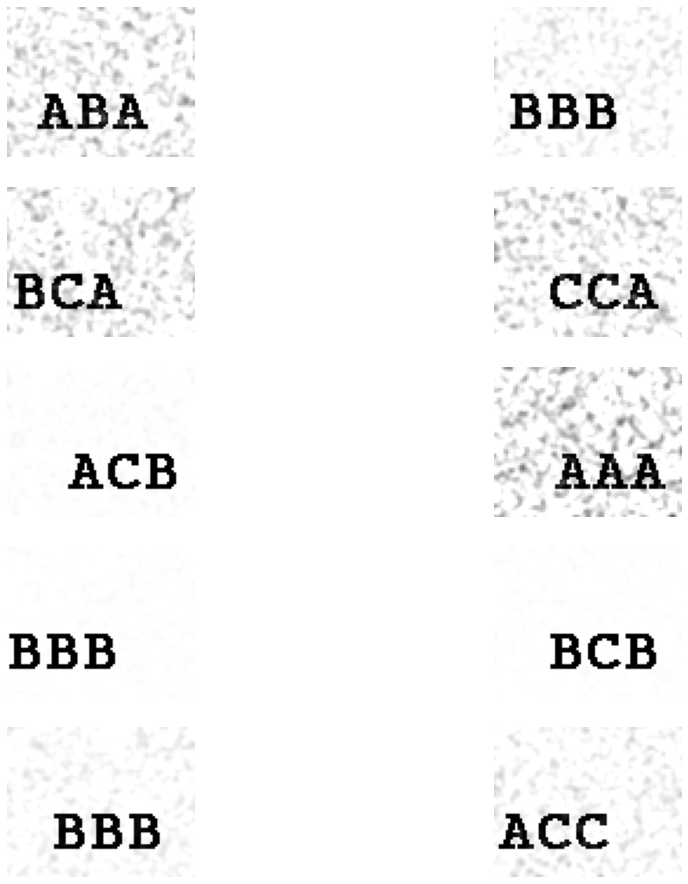

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(16, 16))

axes = axes.flatten()
batch = next(textgen())

print(batch['images'].dtype)
print(batch['images'].shape)

for index in range(10):
    axes[index].imshow(np.squeeze(batch['images'][index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, BatchNormalization, MaxPooling2D, Activation, Reshape, Permute, Bidirectional, LSTM, GRU, Dense, Add, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import SGD

# Show image preparation for network (permute + reverse)

(32, 80, 64, 1)


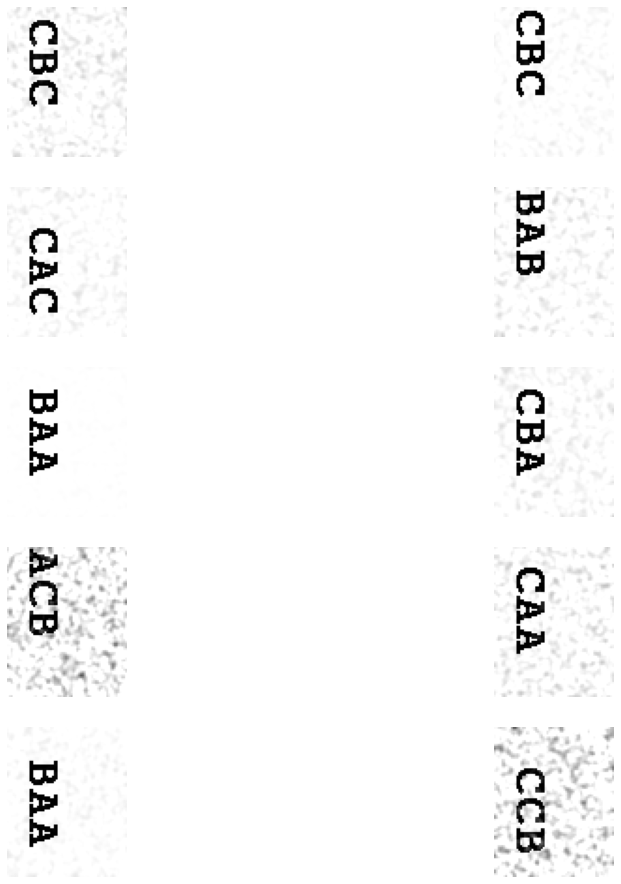

In [6]:
inputs = Input(shape=(HEIGHT, WIDTH, 1), name='input', dtype='float32')

# swap width/height dimension
permute = Permute((2, 1, 3))(inputs)

# reverse last channel to prevent mirroring
permute = Lambda(lambda x: x[:, :, ::-1])(permute)

test_permute_model = Model(inputs=inputs, outputs=permute)

result = test_permute_model(next(textgen()))
print(result.shape)

fig, axes = plt.subplots(5, 2, figsize=(16, 16))
axes = axes.flatten()

for index in range(10):
    axes[index].imshow(np.squeeze(result[index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()


# Create Network Architecture

In [7]:
inputs = Input(shape=(HEIGHT, WIDTH, 1), name='input', dtype='float32')

permute = Permute((2, 1, 3))(inputs)
permute = Lambda(lambda x: x[:, :, ::-1])(permute)

print("after permute", permute.shape)

block_1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(permute)
block_1 = MaxPooling2D((2, 2))(block_1)

block_2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(block_1)
block_2 = MaxPooling2D((2, 1))(block_2)

after_cnn = block_2
print("after cnn", after_cnn.shape)

reshape_conf = (after_cnn.shape[1], after_cnn.shape[2] * after_cnn.shape[3])
TIMESLOTS = after_cnn.shape[1]

after_reshape = Reshape(reshape_conf)(after_cnn)
print("after reshape", after_reshape.shape)

after_reshape = Dense(128, kernel_initializer='he_normal')(after_reshape)

block_rnn = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal'))(after_reshape)
block_rnn = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal'))(block_rnn)
print("block rnn", block_rnn.shape)

dropout = Dropout(0.1)(block_rnn)

tokens = Dense(4, kernel_initializer='he_normal')(dropout)
print("tokens", tokens.shape)

y_pred = Activation('softmax', name="y_activation")(tokens)
print("y pred", y_pred.shape)

pred_model = Model(inputs=inputs, outputs=y_pred)
pred_model.summary()

after permute (None, 80, 64, 1)
after cnn (None, 20, 32, 32)
after reshape (None, 20, 1024)
block rnn (None, 20, 256)
tokens (None, 20, 4)
y pred (None, 20, 4)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 80, 1)]       0         
_________________________________________________________________
permute_1 (Permute)          (None, 80, 64, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (N

# Training

In [8]:
textgen = get_generator(WIDTH, HEIGHT, input_length=TIMESLOTS-2, text_length=3, batch_size=32)

EPOCHS = 500
TRAIN_STEPS = 50
VAL_STEPS = 10
TRAIN = True

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, clipvalue = 0.5)
optimizer = tf.keras.optimizers.Adadelta()
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
training_history = {
    "train_loss": [],
    "val_loss": []
}

def train_step(data):
    with tf.GradientTape() as tape:
        y_pred = pred_model(data['images'], training=True)
        loss = tf.keras.backend.ctc_batch_cost(data['labels'], y_pred[:, 2:, :], data['input_length'], data['label_length'])                
        gradients = tape.gradient(loss, pred_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pred_model.trainable_variables))
        train_loss_metric(loss)
        
def test_step(data):
        y_pred = pred_model(data['images'], training=False)
        loss = tf.keras.backend.ctc_batch_cost(data['labels'], y_pred[:, 2:, :], data['input_length'], data['label_length'])
        val_loss_metric(loss)

if TRAIN:
    for epoch in range(EPOCHS):
        train_loss_metric.reset_states()
        val_loss_metric.reset_states()

        print("Start training epoch {}".format(epoch + 1))
        
        for step in range(TRAIN_STEPS):
            data = next(textgen())
            #print(x['labels'][0])
            train_step(data)
            
        for step in range(VAL_STEPS):
            data = next(textgen())
            test_step(data)
            
        train_loss = train_loss_metric.result()
        val_loss = val_loss_metric.result()
            
        print("Train Loss: {}, Test Loss: {}".format(train_loss, val_loss))
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        
    

Start training epoch 1
Train Loss: 11.891531944274902, Test Loss: 8.49347972869873
Start training epoch 2


KeyboardInterrupt: 

In [ ]:
#save weights after training?
#pred_model.save_weights("./results/lite_seqs_model.h5")

# Training result

In [ ]:
x = [i for i in range(len(training_history['train_loss']))]

fig, ax = plt.subplots()

line1, = ax.plot(x, training_history['train_loss'], label='train_loss')
line2, = ax.plot(x, training_history['val_loss'], label='val_loss')

plt.show()

(32, 20, 4)


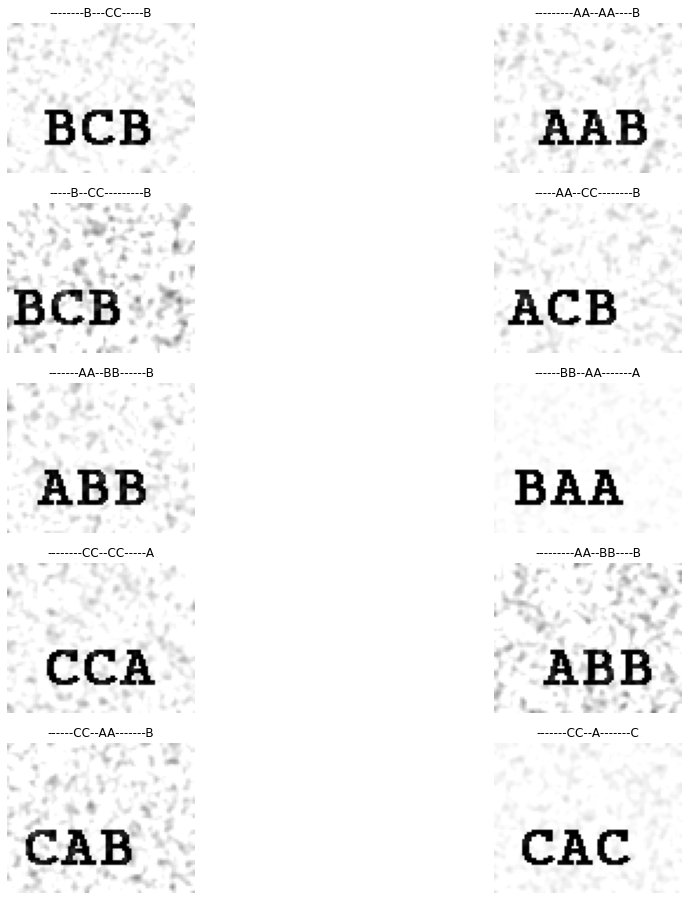

In [9]:
data = next(textgen())

pred_model.load_weights("./results/lite_seqs_model.h5")
y_pred = pred_model(data['images'], training=False)
print(y_pred.shape)

def best_path(sample):
    path = ""
    for col in sample:
        index = np.argmax(col)
        
        if index < len(alphabet):
            path = path + alphabet[index]
        else:
            path = path + "-"
        
    return path

fig, axes = plt.subplots(5, 2, figsize=(16, 16))
axes = axes.flatten()

for index in range(10):   
    axes[index].set_title(best_path(y_pred[index]))
    axes[index].imshow(np.squeeze(data['images'][index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()